In [1]:
import pandas as pd
import numpy as np 

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.model_selection import learning_curve, validation_curve

from flask import Flask,render_template,request,flash
from joblib import dump, load
import pickle

import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# PART A
## Question 1

In [2]:
customer_data = pd.read_csv("CC GENERAL.csv")
print(tabulate(customer_data.head(), headers="keys", tablefmt="rounded_grid"))

╭────┬───────────┬───────────┬─────────────────────┬─────────────┬────────────────────┬──────────────────────────┬────────────────┬───────────────────────┬──────────────────────────────┬────────────────────────────────────┬──────────────────────────┬────────────────────┬─────────────────┬────────────────┬────────────┬────────────────────┬────────────────────┬──────────╮
│    │ CUST_ID   │   BALANCE │   BALANCE_FREQUENCY │   PURCHASES │   ONEOFF_PURCHASES │   INSTALLMENTS_PURCHASES │   CASH_ADVANCE │   PURCHASES_FREQUENCY │   ONEOFF_PURCHASES_FREQUENCY │   PURCHASES_INSTALLMENTS_FREQUENCY │   CASH_ADVANCE_FREQUENCY │   CASH_ADVANCE_TRX │   PURCHASES_TRX │   CREDIT_LIMIT │   PAYMENTS │   MINIMUM_PAYMENTS │   PRC_FULL_PAYMENT │   TENURE │
├────┼───────────┼───────────┼─────────────────────┼─────────────┼────────────────────┼──────────────────────────┼────────────────┼───────────────────────┼──────────────────────────────┼────────────────────────────────────┼──────────────────────────┼────

In [3]:
# dataset column information
customer_data_info = pd.DataFrame({
        "ColumnName": customer_data.columns,
        "Non-Null Count": customer_data.count(),
        "Count of Missing Values": customer_data.isna().sum(),
        "Data Type": customer_data.dtypes
    })
print(tabulate(customer_data_info, headers="keys", showindex=False, tablefmt="fancy_grid"))  
print(f"The dataset is of shape {(customer_data.shape)}.\n Thus it has {customer_data.shape[0]} rows and {customer_data.shape[1]} columns.\n The variety of data types fore each features are float64, int64 and nominal objects")

╒══════════════════════════════════╤══════════════════╤═══════════════════════════╤═════════════╕
│ ColumnName                       │   Non-Null Count │   Count of Missing Values │ Data Type   │
╞══════════════════════════════════╪══════════════════╪═══════════════════════════╪═════════════╡
│ CUST_ID                          │             8950 │                         0 │ object      │
├──────────────────────────────────┼──────────────────┼───────────────────────────┼─────────────┤
│ BALANCE                          │             8950 │                         0 │ float64     │
├──────────────────────────────────┼──────────────────┼───────────────────────────┼─────────────┤
│ BALANCE_FREQUENCY                │             8950 │                         0 │ float64     │
├──────────────────────────────────┼──────────────────┼───────────────────────────┼─────────────┤
│ PURCHASES                        │             8950 │                         0 │ float64     │
├───────────────────

## Question 2

In [4]:
# describe dataset
print(tabulate(customer_data.select_dtypes(include='number').describe(), headers="keys", colalign="center", tablefmt="fancy_grid"))

╒═══════╤═══════════╤═════════════════════╤═════════════╤════════════════════╤══════════════════════════╤════════════════╤═══════════════════════╤══════════════════════════════╤════════════════════════════════════╤══════════════════════════╤════════════════════╤═════════════════╤════════════════╤════════════╤════════════════════╤════════════════════╤════════════╕
│       │   BALANCE │   BALANCE_FREQUENCY │   PURCHASES │   ONEOFF_PURCHASES │   INSTALLMENTS_PURCHASES │   CASH_ADVANCE │   PURCHASES_FREQUENCY │   ONEOFF_PURCHASES_FREQUENCY │   PURCHASES_INSTALLMENTS_FREQUENCY │   CASH_ADVANCE_FREQUENCY │   CASH_ADVANCE_TRX │   PURCHASES_TRX │   CREDIT_LIMIT │   PAYMENTS │   MINIMUM_PAYMENTS │   PRC_FULL_PAYMENT │     TENURE │
╞═══════╪═══════════╪═════════════════════╪═════════════╪════════════════════╪══════════════════════════╪════════════════╪═══════════════════════╪══════════════════════════════╪════════════════════════════════════╪══════════════════════════╪════════════════════╪══════

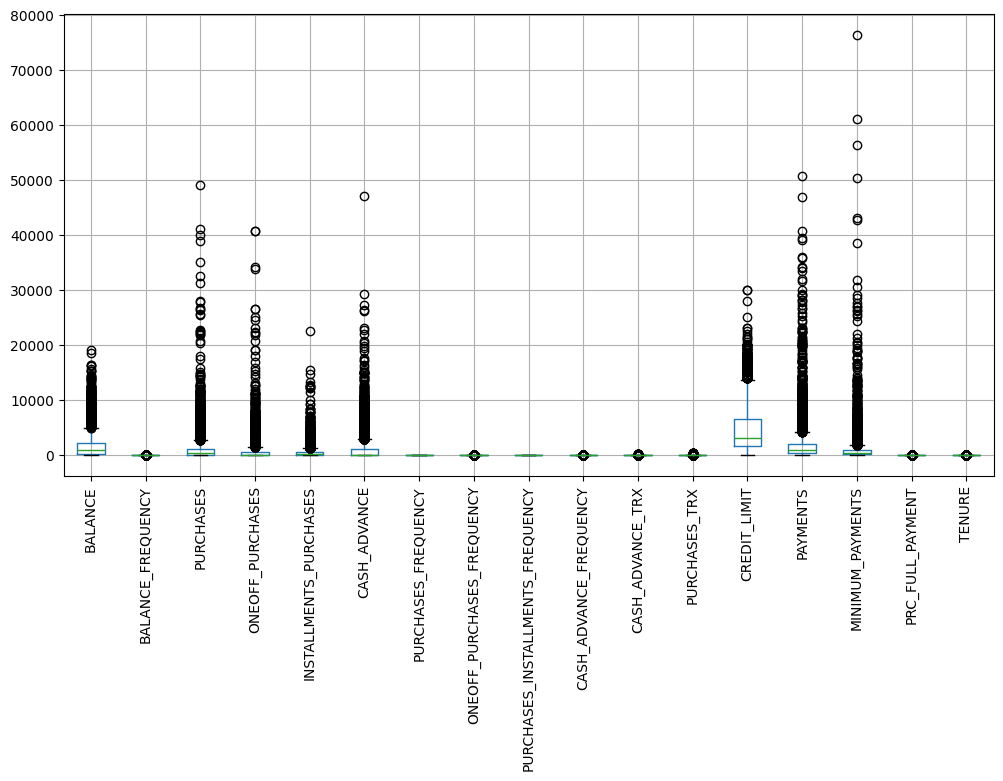

In [5]:
# check for outliers using boxplots
plt.figure(figsize=(12, 6))
customer_data.boxplot()
plt.xticks(rotation=90)
plt.show()

In [6]:
# checking for the number of outliers in each column
def outlier_detect(data):
    # Select numeric columns
    numeric_data = data.select_dtypes(include=['number'])
    
    # Calculate quartiles and IQR
    first_quartile = numeric_data.quantile(0.25)
    third_quartile = numeric_data.quantile(0.75)
    int_quartile_range = third_quartile - first_quartile
    
    # Detect outliers
    outliers = numeric_data[
        (numeric_data < (first_quartile - 1.5 * int_quartile_range)) |
        (numeric_data > (third_quartile + 1.5 * int_quartile_range))
    ]
    
    return outliers

outliers_count = outlier_detect(customer_data).notna().sum()

print("===================== SUMMARY OF OUTLIERS ======================")
print(tabulate(outliers_count.reset_index(), headers=["Column", "Number of Outliers"], tablefmt="fancy_grid"))


===================== SUMMARY OF OUTLIERS ======================
╒════╤══════════════════════════════════╤══════════════════════╕
│    │ Column                           │   Number of Outliers │
╞════╪══════════════════════════════════╪══════════════════════╡
│  0 │ BALANCE                          │                  695 │
├────┼──────────────────────────────────┼──────────────────────┤
│  1 │ BALANCE_FREQUENCY                │                 1493 │
├────┼──────────────────────────────────┼──────────────────────┤
│  2 │ PURCHASES                        │                  808 │
├────┼──────────────────────────────────┼──────────────────────┤
│  3 │ ONEOFF_PURCHASES                 │                 1013 │
├────┼──────────────────────────────────┼──────────────────────┤
│  4 │ INSTALLMENTS_PURCHASES           │                  867 │
├────┼──────────────────────────────────┼──────────────────────┤
│  5 │ CASH_ADVANCE                     │                 1030 │
├────┼───────────────────

It is observed that every column apart from Purchases Frequency and Purchases Inatllments_Frequency have outliers in their respective observations.

In [7]:
num_of_duplicates = customer_data.duplicated().sum()
print(f"The number of duplicates in the data is {num_of_duplicates}")

The number of duplicates in the data is 0


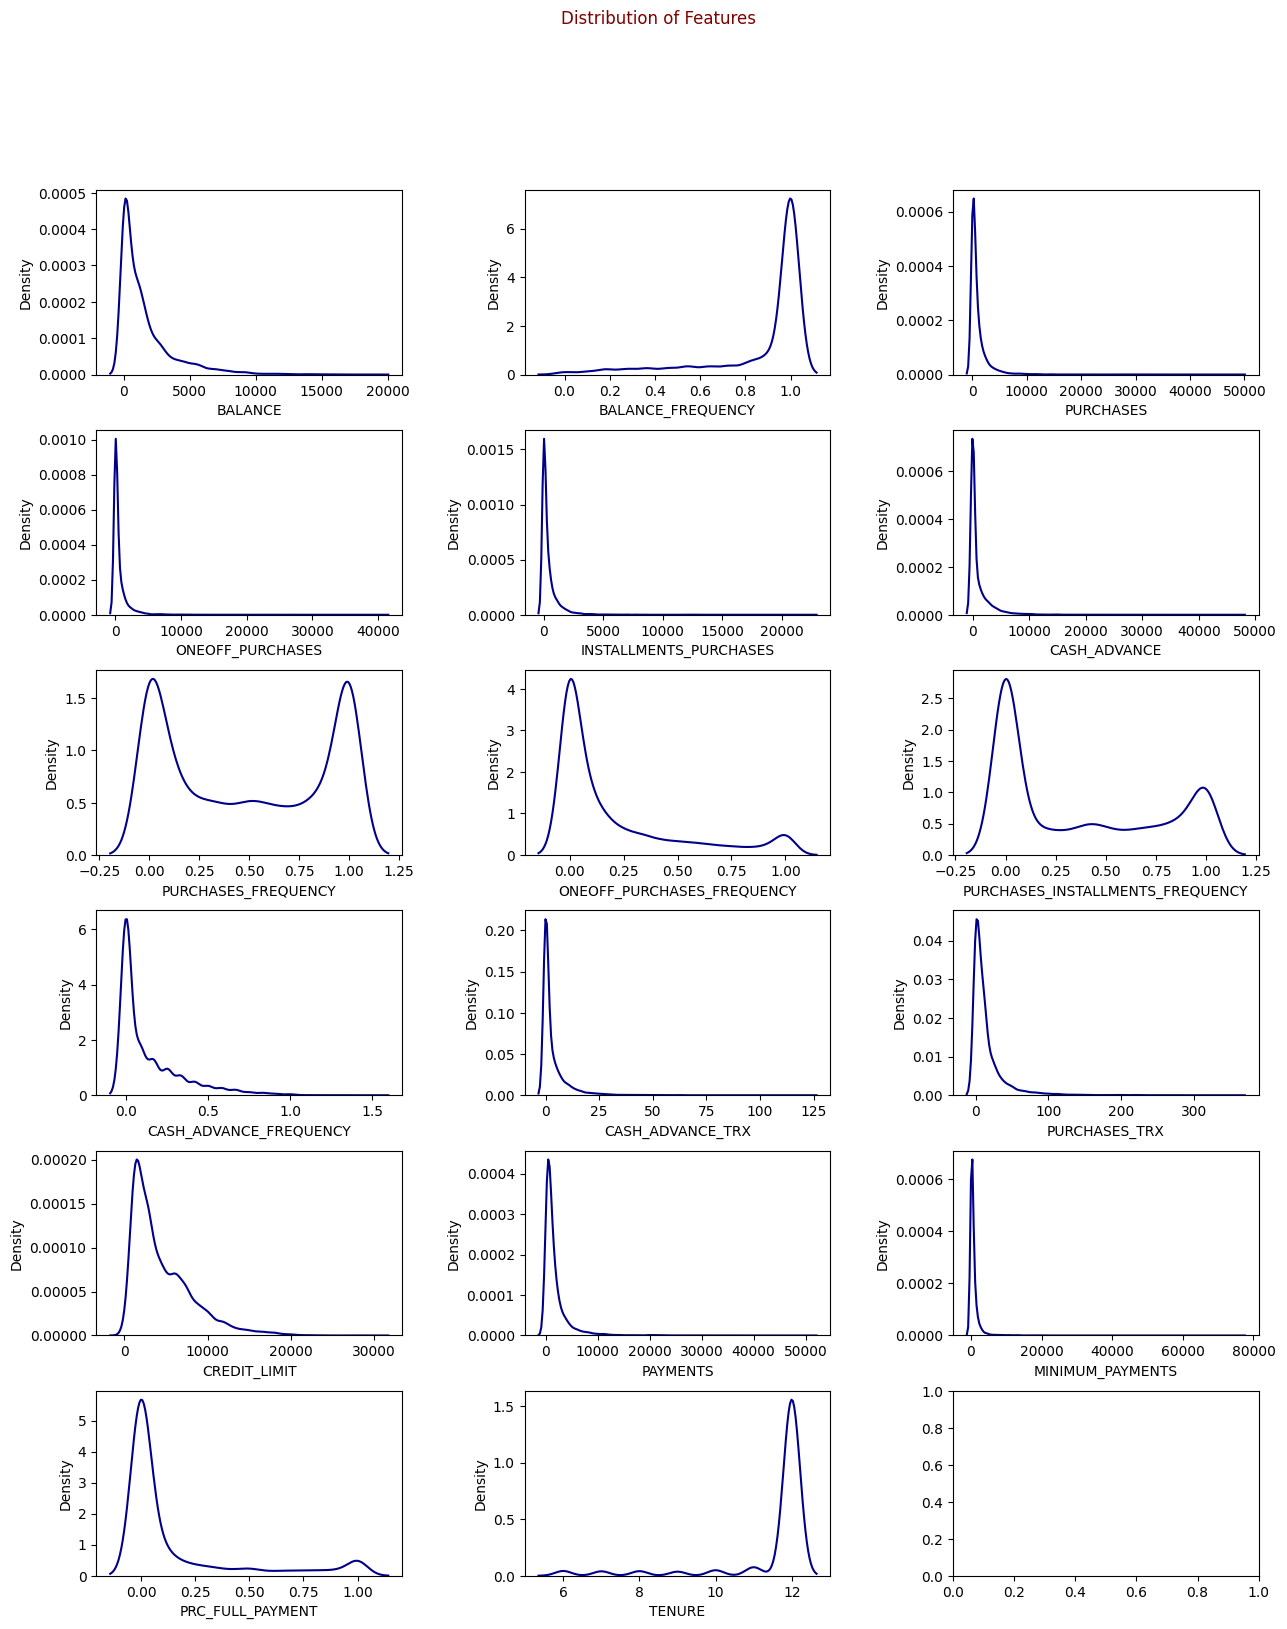

In [8]:
# exploring the distribution of each column
features = [col for col in customer_data.iloc[:, 1:]]

fig, axes = plt.subplots(6, 3, figsize=(15, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
plt.suptitle("Distribution of Features", color="maroon")

for col_num, col in enumerate(features):
    row_num, col_in_row = divmod(col_num, 3)
    sns.kdeplot(data=customer_data[col], color=(0/255, 0/255, 139/255), ax=axes[row_num, col_in_row])

plt.show()


The distribution of the features reveal that two variables namely Purchases Frequency and Purchases Installments Frequency are bimodal, there is a slight bimodal tendency in One-Off Purchses Frequency. All other features are mostly right-skwed with the remnant, left-skewed.

## Question 3 Preprocessing

### Question 3a and 3b

In [9]:

# drop the customer ID column
customer_data.drop("CUST_ID", axis=1, inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy="median")
filled_customer_data = pd.DataFrame(imputer.fit_transform(customer_data.select_dtypes(include="number")), columns=customer_data.columns)

# Data scaling using StandardScaler
scaler = StandardScaler()
scaled_customer_data = pd.DataFrame(scaler.fit_transform(filled_customer_data), columns=filled_customer_data.columns)

with open('standard_scaler.pkl', 'wb') as scaler_tool:
    pickle.dump(scaler, scaler_tool)

with open('standard_scaler.pkl', 'rb') as scaler_tool:
    loaded_scaler = pickle.load(scaler_tool)    

In [39]:
sel = ["PURCHASES_FREQUENCY", "ONEOFF_PURCHASES", "INSTALLMENTS_PURCHASES", "BALANCE", "PURCHASES", "CASH_ADVANCE_TRX", "ONEOFF_PURCHASES_FREQUENCY", "CASH_ADVANCE", "PURCHASES_TRX", "CASH_ADVANCE_FREQUENCY"]
imp_X = filled_customer_data.loc[:,sel]
new_scaler = StandardScaler()
new_scaled_X = new_scaler.fit_transform(imp_X)

In [40]:
with open('new_standard_scaler.pkl', 'wb') as new_scaler_tool:
    pickle.dump(new_scaler, new_scaler_tool)

with open('new_standard_scaler.pkl', 'rb') as new_scaler_tool:
    new_loaded_scaler = pickle.load(new_scaler_tool) 

There were observed missing values in some columns thus these were filled with their respective medians. Data scaling was also performed to ensure a uniform scale for which each feature measured.

## Question 4 Unsupervised model creation and evaluation (Clustering) using KMeans

### Question 4a

  File "C:\Users\Emmanuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

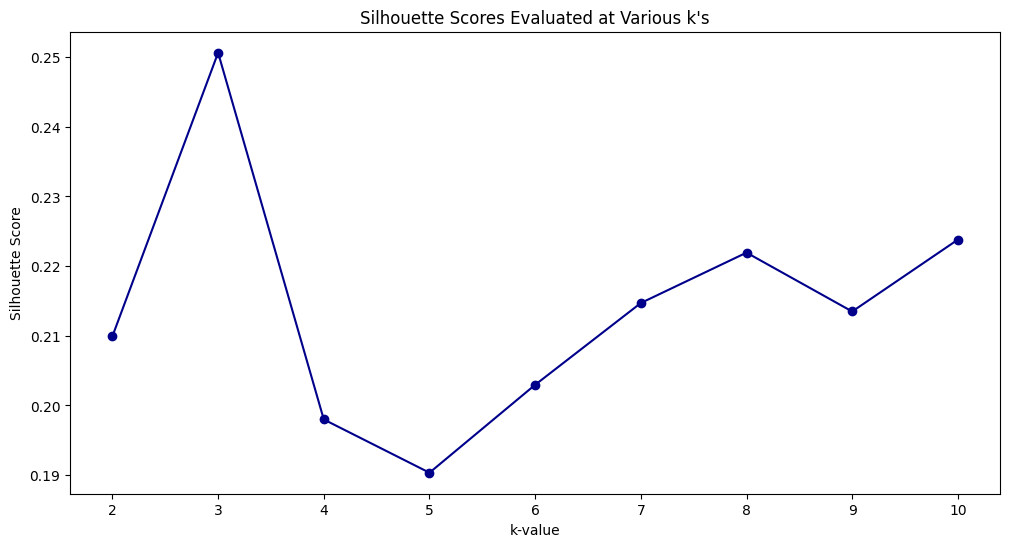

In [10]:

# plot silhouette scores for each k to evaluate the best k
sil_scores = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, n_init=10).fit(scaled_customer_data)
  labels = kmeans.labels_
  sil_scores.append(silhouette_score(scaled_customer_data, labels, metric = "euclidean"))

plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), sil_scores, color=(0/255, 0/255, 139/255), marker="o")
plt.title("Silhouette Scores Evaluated at Various k's")
plt.xlabel("k-value")
plt.ylabel("Silhouette Score")
plt.show()

The Silhouette scores measure the optimal number of clusters. The optimal k is maximized by the largest Silhouette value thus it can be observed that the scores peak at three with a value of about 25%.

### Question 4b

In [11]:
# fitting KMeans model with three clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans.fit(scaled_customer_data)

# Evaluate the clustering model
silhouette_avg = silhouette_score(scaled_customer_data, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)


# Label the entire dataset
filled_customer_data["Cluster_Labels"] = kmeans.labels_
scaled_customer_data["Cluster_Labels"] = kmeans.labels_

# Save the labeled dataset
filled_customer_data.to_csv('eaadjei-cc-labeled.csv', index=False)
scaled_customer_data.to_csv('eaadjei-cc-labeled.csv', index=False)

Silhouette Score: 0.25098792290537314


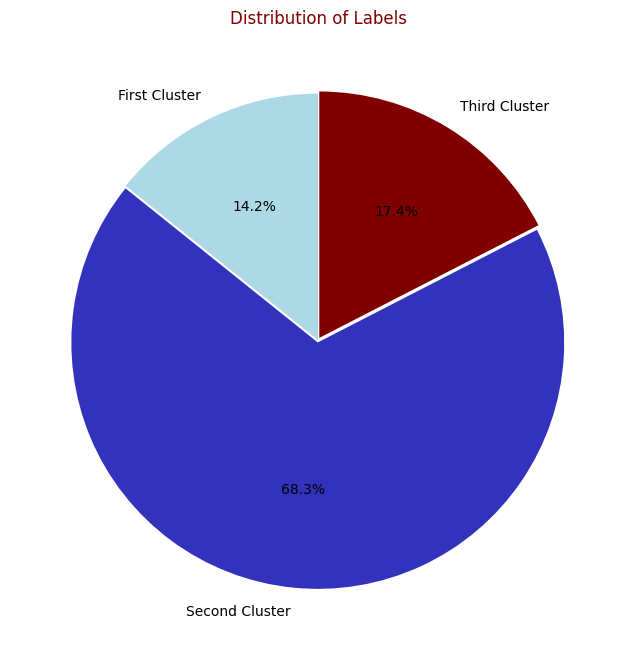

In [12]:
# check for the distribution of labels

# Count the occurrences of each unique value in the <<Cluster_Labels>> column
first_cluster_count = filled_customer_data[filled_customer_data.Cluster_Labels == 0].shape[0]
second_cluster_count = filled_customer_data[filled_customer_data.Cluster_Labels == 1].shape[0]
third_cluster_count = filled_customer_data[filled_customer_data.Cluster_Labels == 2].shape[0]

# Create a pie chart
distribution_dict = {"First Cluster":first_cluster_count, "Second Cluster": second_cluster_count, "Third Cluster": third_cluster_count}
colors = ["lightblue", (50/255, 50/255, 189/255), "maroon"]

plt.figure(figsize=(8, 8))
plt.pie(distribution_dict.values(), labels=distribution_dict.keys(), autopct='%1.1f%%', explode=[0, 0.01,0.01], startangle=90, colors=colors)
plt.title('Distribution of Labels', color="maroon")
plt.show()


After obtaining the labels from the unsupervised model, the label distribution is observed and it is seen that the second cluster has the highest distribution thus the data labels is imbalanced.

# Question 5: Supervised model creation and evaluation (Classification)

### Question 5a

In [13]:
# specify the number of folds and strategy
kfolds = StratifiedKFold(n_splits=10, shuffle=False)

# Prepare features and target variables based on scaled data
X = scaled_customer_data.drop(["Cluster_Labels"], axis=1)
y = scaled_customer_data["Cluster_Labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# create and evaluate a Random Forest classifier based on cross-validation
rf_classifier = RandomForestClassifier(random_state=42)
lr_model1 = LogisticRegression(random_state=42)

rf_balanced_accuracy_score = np.mean(cross_val_score(rf_classifier, X_train, y_train, cv=kfolds, scoring="balanced_accuracy"))
lr1_balanced_accuracy_score = np.mean(cross_val_score(lr_model1, X_train, y_train, cv=kfolds, scoring="balanced_accuracy"))

# Create scores_list
scores_list = [["Metric", "Score"],
               ["RF Balanced Accuracy", rf_balanced_accuracy_score],
               ["Logistic Balanced Accuracy", lr1_balanced_accuracy_score]
              ]

# Print the table using tabulate
print(tabulate(scores_list, headers="firstrow", tablefmt="fancy_grid"))

╒════════════════════════════╤══════════╕
│ Metric                     │    Score │
╞════════════════════════════╪══════════╡
│ RF Balanced Accuracy       │ 0.947786 │
├────────────────────────────┼──────────┤
│ Logistic Balanced Accuracy │ 0.991019 │
╘════════════════════════════╧══════════╛


The metrics for the random forest indicate that the logistic model performs better. This metric is however based on the balanced accuracy score due to imbalance in the labels.

In [14]:
# saving models
with open('rf_classifier_model.pkl', 'wb') as rf_file:
    pickle.dump(rf_classifier, rf_file)

# Save the LogisticRegression model using pickle
with open('lr_model1.pkl', 'wb') as l_file:
    pickle.dump(lr_model1, l_file)


with open('rf_classifier_model.pkl', 'rb') as rf_file:
    loaded_rf_classifier = pickle.load(rf_file)

with open('lr_model1.pkl', 'rb') as l_file:
    loaded_lr_model1 = pickle.load(l_file)


### Model Debugging

In [15]:
# constructing the learning curves for logistic and regression models


rf_train_sizes, rf_train_scores, rf_test_scores=learning_curve(estimator=rf_classifier, X=X_train, y=y_train,\
                                                     train_sizes=np.linspace(0.1,1.0,10),cv=10, scoring="balanced_accuracy")

lr1_train_sizes, lr1_train_scores, lr_test_scores=learning_curve(estimator=lr_model1, X=X_train, y=y_train,\
                                                     train_sizes=np.linspace(0.1,1.0,10),cv=10, scoring="balanced_accuracy")

rf_train_mean=np.mean(rf_train_scores,axis=1)
rf_train_std=np.std(rf_train_scores,axis=1) #used to indicate the variance of estimate.

rf_test_mean=np.mean(rf_test_scores,axis=1)
rf_test_std=np.std(rf_test_scores,axis=1)


lr1_train_mean=np.mean(lr1_train_scores,axis=1)
lr1_train_std=np.std(lr1_train_scores,axis=1) #used to indicate the variance of estimate.

lr1_test_mean=np.mean(lr_test_scores,axis=1)
lr1_test_std=np.std(lr_test_scores,axis=1)



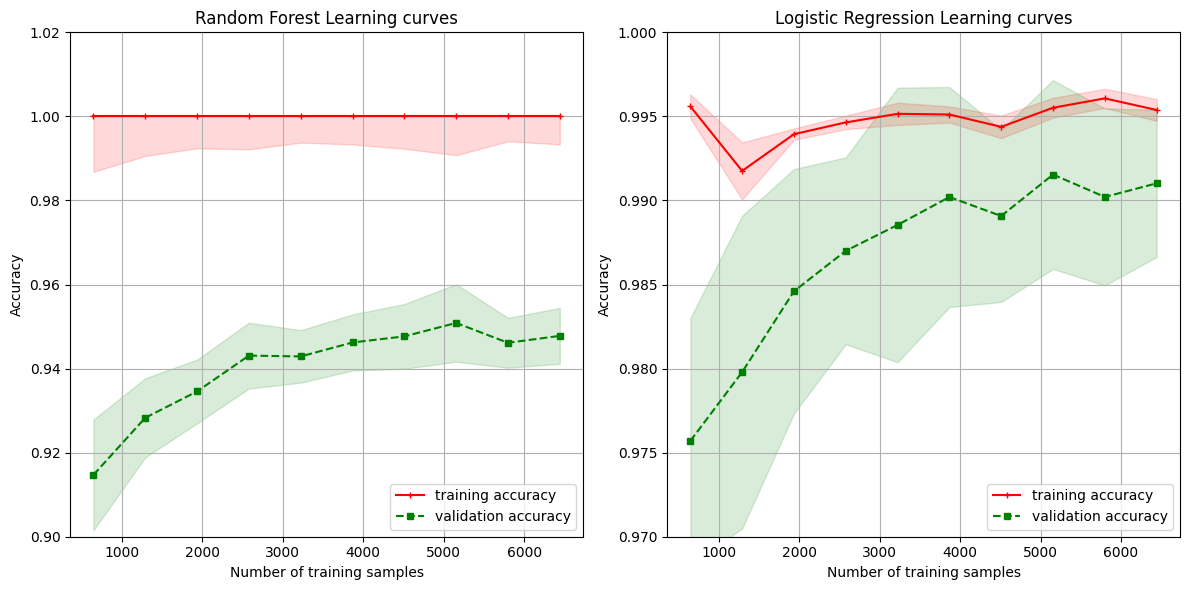

In [16]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotting the Learning Curve for Random Forest Classifier
axes[0].plot(rf_train_sizes, rf_train_mean, color='red', marker='+', markersize=5, label='training accuracy')
axes[0].fill_between(rf_train_sizes, rf_train_mean + rf_train_std, rf_train_mean - rf_test_std, alpha=0.15, color='red')
axes[0].plot(rf_train_sizes, rf_test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
axes[0].fill_between(rf_train_sizes, rf_test_mean + rf_test_std, rf_test_mean - rf_test_std, alpha=0.15, color='green')
axes[0].grid()
axes[0].set_xlabel('Number of training samples')
axes[0].set_ylabel('Accuracy')
axes[0].set_title("Random Forest Learning curves")
axes[0].legend(loc='lower right')
axes[0].set_ylim([0.9, 1.02])

# Plotting the Learning Curve for Logistic Regression
axes[1].plot(lr1_train_sizes, lr1_train_mean, color='red', marker='+', markersize=5, label='training accuracy')
axes[1].fill_between(lr1_train_sizes, lr1_train_mean + lr1_train_std, lr1_train_mean - lr1_train_std, alpha=0.15, color='red')
axes[1].plot(lr1_train_sizes, lr1_test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
axes[1].fill_between(lr1_train_sizes, lr1_test_mean + lr1_test_std, lr1_test_mean - lr1_test_std, alpha=0.15, color='green')
axes[1].grid()
axes[1].set_xlabel('Number of training samples')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Logistic Regression Learning curves")
axes[1].legend(loc='lower right')
axes[1].set_ylim([0.97, 1.0])

plt.tight_layout()
plt.show()



The learning curves for both models similarly improve with more training samples. However, there seems to be overfitting with the random forest since the in-sample scores remain constant at one but the gap between the cross-validated score does not converge. The logistic model on the other hand, performs better since there is a convergent tendency between the in-sample and out od sample data.

### Question 5b

Use learning curves to determine whether the model is overfitting or
underfitting the data. Add mark down cells to comment on the results

In [17]:
rfc_param_range = [10, 50, 100, 200, 300]  # the number of trees

lr2_param_range=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] #regularization penalty
lr_model2=LogisticRegression(random_state=42)

# Validation Curve for the random 
rfc_train_scores, rfc_test_scores = validation_curve( estimator=rf_classifier, X=X_train, y=y_train, param_name='n_estimators',\
                                              param_range=rfc_param_range, cv=10, scoring="balanced_accuracy")

rfc_train_mean=np.mean(rfc_train_scores,axis=1)
rfc_train_std=np.std(rfc_train_scores,axis=1) #used to indicate the variance of estimate.

rfc_test_mean=np.mean(rfc_test_scores,axis=1)
rfc_test_std=np.std(rfc_test_scores,axis=1)


lr2_train_scores, lr2_test_scores=validation_curve(estimator=lr_model2, X=X_train, y=y_train,\
                                                     param_name='C', param_range=lr2_param_range, cv=10, scoring="balanced_accuracy")

# Calculate mean and standard deviation for training and test scores
lr2_train_mean = np.mean(lr2_train_scores, axis=1)
lr2_train_std = np.std(lr2_train_scores, axis=1)
lr2_test_mean = np.mean(lr2_test_scores, axis=1)
lr2_test_std = np.std(lr2_test_scores, axis=1)


In [18]:
# Find the best number of trees for RandomForestClassifier
best_rfc_param_index = np.argmax(rfc_test_mean)
best_rfc_param = rfc_param_range[best_rfc_param_index]
best_rfc_mean_score = rfc_test_mean[best_rfc_param_index]

print("Best RandomForestClassifier Parameters:")
print("Number of Trees:", best_rfc_param)
print("Mean Balanced Accuracy:", best_rfc_mean_score)

# Find the best regularization penalty for LogisticRegression
best_lr2_param_index = np.argmax(lr2_test_mean)
best_lr2_param = lr2_param_range[best_lr2_param_index]
best_lr2_mean_score = lr2_test_mean[best_lr2_param_index]

print("\nBest LogisticRegression Parameters:")
print("Regularization Penalty (C):", best_lr2_param)
print("Mean Balanced Accuracy:", best_lr2_mean_score)


Best RandomForestClassifier Parameters:
Number of Trees: 300
Mean Balanced Accuracy: 0.950183630095132

Best LogisticRegression Parameters:
Regularization Penalty (C): 100.0
Mean Balanced Accuracy: 0.9946667099512995


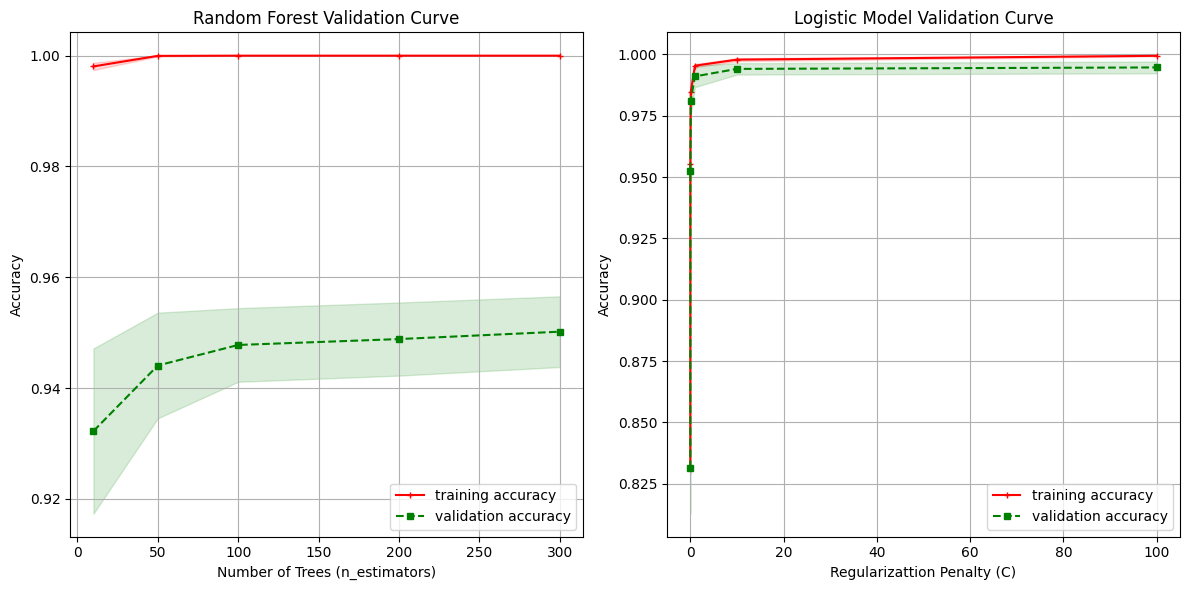

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the Validation Curve for the Random Forest Classifier
axes[0].plot(rfc_param_range, rfc_train_mean, color='red', marker='+', markersize=5, label='training accuracy')
axes[0].fill_between(rfc_param_range, rfc_train_mean + rfc_train_std, rfc_train_mean - rfc_train_std, alpha=0.15, color='red')
axes[0].plot(rfc_param_range, rfc_test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
axes[0].fill_between(rfc_param_range, rfc_test_mean + rfc_test_std, rfc_test_mean - rfc_test_std, alpha=0.15, color='green')
axes[0].grid()
axes[0].set_xlabel('Number of Trees (n_estimators)')
axes[0].set_ylabel('Accuracy')
axes[0].set_title("Random Forest Validation Curve")
axes[0].legend(loc='lower right')

# Plotting the Validation Curve for the Logistic Model
axes[1].plot(lr2_param_range, lr2_train_mean, color='red', marker='+', markersize=5, label='training accuracy')
axes[1].fill_between(lr2_param_range, lr2_train_mean + lr2_train_std, lr2_train_mean - lr2_train_std, alpha=0.15, color='red')
axes[1].plot(lr2_param_range, lr2_test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
axes[1].fill_between(lr2_param_range, lr2_test_mean + lr2_test_std, lr2_test_mean - lr2_test_std, alpha=0.15, color='green')
axes[1].grid()
axes[1].set_xlabel('Regularizattion Penalty (C)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Logistic Model Validation Curve")
axes[1].legend(loc='lower right')



plt.tight_layout()
plt.show()

### Question 5c

The validation curve also shows that the logistic model is better than the random forest model since the deviation of the validation accuracy from the train accuracy is relatively lesser. The classification models considered were the logistic model and a random forest classifier. Both are suitable for classifying but since the random forest classifier is a complex model albeit a generally higher predictive power, the logistic model is preferred.

# Question 6 Feature Selection and Engineering


### Question 6a

Random Forest Mean Accuracy (Selected Features): 0.9477861341383532


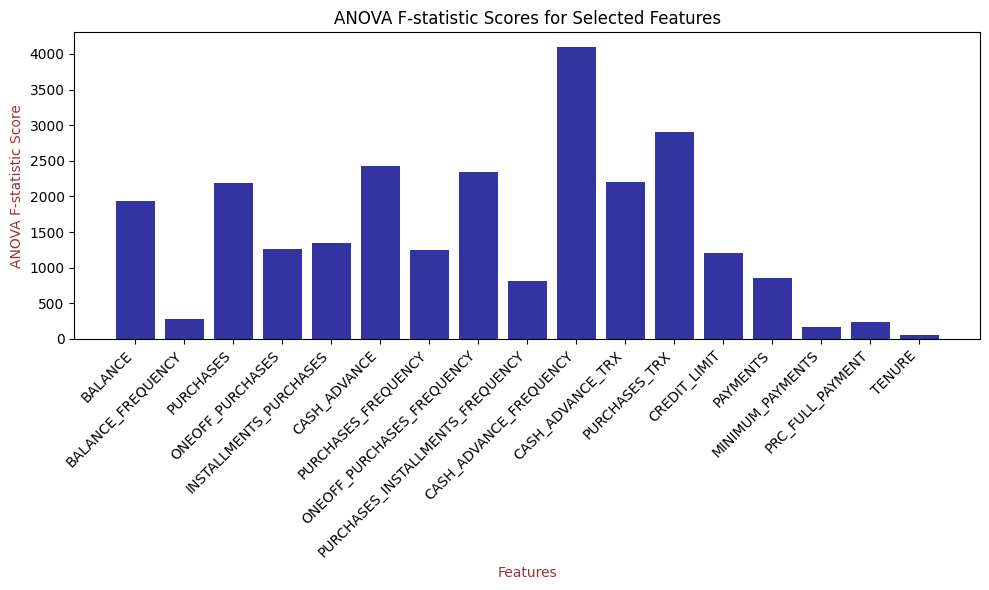

In [20]:

# Perform feature selection using SelectKBest and f_classif
rfc_feature_selector = SelectKBest(f_classif, k=17)
rfc_X_selected = rfc_feature_selector.fit_transform(X_train, y_train)
rfc_selected_features = X_train.columns[rfc_feature_selector.get_support()]
rfc_scores = rfc_feature_selector.scores_

# Build and evaluate a new Random Forest classifier based on the selected features
rf_classifier_selected = RandomForestClassifier(random_state=42)
rfc_scores_selected = cross_val_score(rf_classifier_selected, rfc_X_selected, y_train, cv=kfolds, scoring="balanced_accuracy")
rfc_mean_accuracy_selected = np.mean(rfc_scores_selected)
rf_top_10_indices = np.argsort(rfc_scores)[-10:]
rf_top_10_features = rfc_selected_features[rf_top_10_indices]
rf_top_10_scores = rfc_scores[rf_top_10_indices]

# Print or use top_10_features and top_10_scores as needed
print("Random Forest Mean Accuracy (Selected Features):", rfc_mean_accuracy_selected)

plt.figure(figsize=(10, 6))
plt.bar(rfc_selected_features, rfc_scores, color=(0/255, 0/255, 139/255), alpha=0.8)
plt.title('ANOVA F-statistic Scores for Selected Features')
plt.xlabel('Features', color="maroon", alpha=0.8)
plt.ylabel('ANOVA F-statistic Score', color="maroon", alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The plot shows the importances of each feature based on the ANOVA score. Features such as PRC_FULL_PAYMENT and TENURE are observed to be irrelevant while CASH_ADVANCE_FREQUENCY and PURCHASE_TRX are highly relevant.

In [21]:
# top 10 features
rf_top_10_features_data = list(zip(rf_top_10_features, rf_top_10_scores))

print(tabulate(rf_top_10_features_data, headers=["Feature", "Score"], tablefmt="fancy_grid"))

╒════════════════════════════╤═════════╕
│ Feature                    │   Score │
╞════════════════════════════╪═════════╡
│ PURCHASES_FREQUENCY        │ 1254.54 │
├────────────────────────────┼─────────┤
│ ONEOFF_PURCHASES           │ 1262.82 │
├────────────────────────────┼─────────┤
│ INSTALLMENTS_PURCHASES     │ 1343.72 │
├────────────────────────────┼─────────┤
│ BALANCE                    │ 1936.93 │
├────────────────────────────┼─────────┤
│ PURCHASES                  │ 2188.04 │
├────────────────────────────┼─────────┤
│ CASH_ADVANCE_TRX           │ 2198.72 │
├────────────────────────────┼─────────┤
│ ONEOFF_PURCHASES_FREQUENCY │ 2340.91 │
├────────────────────────────┼─────────┤
│ CASH_ADVANCE               │ 2424.24 │
├────────────────────────────┼─────────┤
│ PURCHASES_TRX              │ 2909.83 │
├────────────────────────────┼─────────┤
│ CASH_ADVANCE_FREQUENCY     │ 4098.94 │
╘════════════════════════════╧═════════╛


In [22]:

# Perform feature selection using SelectKBest and f_classif
lr_feature_selector = SelectKBest(f_classif, k=17)
lr_X_selected = lr_feature_selector.fit_transform(X_train, y_train)
lr_selected_features = X_train.columns[lr_feature_selector.get_support()]
lr_scores = lr_feature_selector.scores_

# Build and evaluate a new Random Forest classifier based on the selected features
lr_classifier_selected = LogisticRegression(random_state=42)
lr_scores_selected = cross_val_score(lr_classifier_selected, lr_X_selected, y_train, cv=kfolds, scoring="balanced_accuracy")
lr_mean_accuracy_selected = np.mean(lr_scores_selected)

lr_top_10_indices = np.argsort(lr_scores)[-10:]
lr_top_10_features = lr_selected_features[lr_top_10_indices]
lr_top_10_scores = lr_scores[lr_top_10_indices]

# Print or use top_10_features and top_10_scores as needed
print("Logistic Regression Mean Accuracy (Selected Features):", lr_mean_accuracy_selected)


lr_top_10_features_data = list(zip(lr_top_10_features, lr_top_10_scores))

# Create a table using tabulate
print(tabulate(lr_top_10_features_data, headers=["Feature", "Score"], tablefmt="fancy_grid"))


Logistic Regression Mean Accuracy (Selected Features): 0.9910193719743019
╒════════════════════════════╤═════════╕
│ Feature                    │   Score │
╞════════════════════════════╪═════════╡
│ PURCHASES_FREQUENCY        │ 1254.54 │
├────────────────────────────┼─────────┤
│ ONEOFF_PURCHASES           │ 1262.82 │
├────────────────────────────┼─────────┤
│ INSTALLMENTS_PURCHASES     │ 1343.72 │
├────────────────────────────┼─────────┤
│ BALANCE                    │ 1936.93 │
├────────────────────────────┼─────────┤
│ PURCHASES                  │ 2188.04 │
├────────────────────────────┼─────────┤
│ CASH_ADVANCE_TRX           │ 2198.72 │
├────────────────────────────┼─────────┤
│ ONEOFF_PURCHASES_FREQUENCY │ 2340.91 │
├────────────────────────────┼─────────┤
│ CASH_ADVANCE               │ 2424.24 │
├────────────────────────────┼─────────┤
│ PURCHASES_TRX              │ 2909.83 │
├────────────────────────────┼─────────┤
│ CASH_ADVANCE_FREQUENCY     │ 4098.94 │
╘═══════════════════════

### Question 6b

In [62]:

selected_X = X_train[lr_top_10_features]
new_lr_model = LogisticRegression(random_state=42, C=100.0).fit(selected_X, y_train)

new_lr_model_balanced_accuracy_score = np.mean(cross_val_score(new_lr_model, selected_X, y_train, cv=kfolds, scoring="balanced_accuracy"))


with open('eaadjei_new_lr_model.pkl', 'wb') as file:
    pickle.dump(new_lr_model, file)

# Load the model back using pickle
with open('eaadjei_new_lr_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


print("New Balanced Accuracy Score:", new_lr_model_balanced_accuracy_score)

New Balanced Accuracy Score: 0.9461052013081798


In [63]:
selected_X.shape

(7160, 10)

### Question 6c

The model with fewer selected features performs better than using all the features. Whereas with 10 features, the logistic model scores 99.4%, the model with all features gives an accuracy of about 99.1%.

# Question 7 Hyperparameter Tuning

### Question 7a
The selected benchmark model model is the logistic model with selected features since it is relatively parsimonious (new_lr_model)

In [67]:

# Hyperparameter Tuning for logistic regression
lr_benchmark_model = LogisticRegression(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],        # Regularization term
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Inverse of regularization strength
    'fit_intercept': [True, False],  
    'solver': ['liblinear', 'saga'], 
    'max_iter': [100, 200, 300],  
    'class_weight': [None, 'balanced'],  
    'multi_class': ['ovr', 'multinomial'], 
}


# Perform hyperparameter tuning using Grid Search
lr_grid_search = GridSearchCV(lr_benchmark_model, param_grid, cv=kfolds, n_jobs=-1, scoring="balanced_accuracy")
lr_grid_search.fit(selected_X, y_train)

# Get the best model and its parameters
lr_best_model = lr_grid_search.best_estimator_
lr_best_params = lr_grid_search.best_params_
lr_best_score = lr_grid_search.best_score_
print("Best Logistic  Model:", lr_best_model)
print("Best Logistic Parameters:", lr_best_params)
print("Best Logistic Score:", lr_best_score)


Best Logistic  Model: LogisticRegression(C=10.0, class_weight='balanced', max_iter=300,
                   multi_class='multinomial', penalty='l1', random_state=42,
                   solver='saga')
Best Logistic Parameters: {'C': 10.0, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 300, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}
Best Logistic Score: 0.9569003064588509


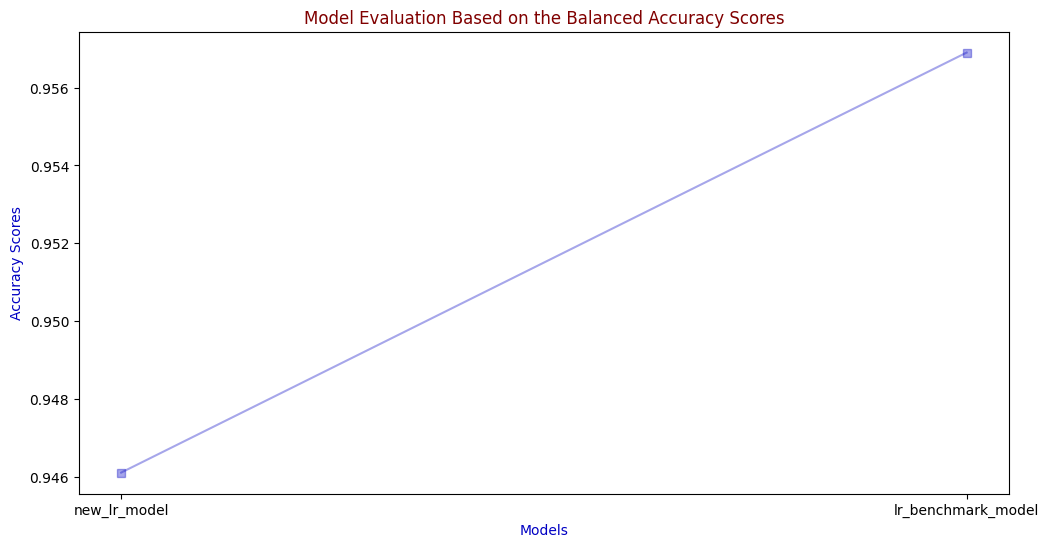

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(["new_lr_model", "lr_benchmark_model"], [new_lr_model_balanced_accuracy_score, lr_best_score], color=(0/255, 0/255, 195/255), marker="s",alpha=0.35)
plt.title("Model Evaluation Based on the Balanced Accuracy Scores", color="maroon")
plt.xlabel("Models", color=(0/255, 0/255, 195/255))
plt.ylabel("Accuracy Scores", color=(0/255, 0/255, 195/255))
plt.show()

In [71]:
with open('eaadjei_hypertuned_model.pkl', 'wb') as hypertuned_model:
    pickle.dump(lr_best_model, hypertuned_model)

# Load the model back using pickle
with open('eaadjei_hypertuned_model.pkl', 'rb') as hypertuned_model:
    tuned_loaded_model = pickle.load(hypertuned_model)

### Question 7b

The selected hyper-parameters are provide the combination of parameters for which the model is best. The "C" parameter is to penalize the model when features are added such that the dataset is regularized. The mode for which the penalty checks which penalizing strategy between the l1 and l2 norms are better. Also thr maximum number of iterations is the threshold for which the model converges reaches. The class weight parameter accounts of whether the strcuture of labels is conss=idered. 

### Question 7c
The best model is thus the hyper-tuned model

In [72]:
# choosing the final model
final_benchmark_model = tuned_loaded_model

# Save model
with open('eaadjei_final_benchmark_model.pkl', 'wb') as fb_model:
    pickle.dump(final_benchmark_model, fb_model)

# Load the model back using pickle
with open('eaadjei_final_benchmark_model.pkl', 'rb') as fb_model:
    loaded_final_benchmark_model = pickle.load(fb_model)

In [28]:
cluster_characteristics = filled_customer_data.groupby('Cluster_Labels').mean()
cluster_characteristics

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster_Labels,,,,,,,,,,,,,,,,,
0,2182.352833,0.981702,4187.017796,2663.995153,1523.493231,449.753140,0.948175,0.664780,0.739630,0.062415,1.507451,55.692549,7642.784314,4075.533648,1227.915879,0.298766,11.916863
1,807.722510,0.834577,496.062522,247.273214,249.110368,338.996760,0.460353,0.129191,0.342052,0.069563,1.236833,8.480046,3267.022176,907.446164,530.068546,0.154115,11.475793
2,4023.788865,0.959193,389.051448,252.333261,136.797412,3917.254973,0.233899,0.111806,0.145661,0.451410,12.551570,5.636131,6729.471201,3053.943771,1765.204181,0.033673,11.353619


Based on the average credit levels and balance, customers clusterd as 0 can be inferred to have high credit worth whereas customewrs labelled as 1 ahve low credit worth. Those clustered as to can also be categorized as relatively fair thus specific products can be designed based on a niche of these segmentations. 

# Question 8 Model Deployment

In [29]:
# Perform predictions using the loaded model
new_instance_selected = X_train
predicted_cluster = loaded_final_benchmark_model.predict(new_instance_selected)
print("Predicted Cluster Label:", predicted_cluster)

Predicted Cluster Label: [1 1 1 ... 1 1 1]


In [73]:

# Assuming you have 10 features for the data points
data_points = np.array([120, 13, 3647, 16237, 3474, 225634, 1142, 336, 447, 227])

# Reshape the array to have 10 features
data_points_reshaped = data_points.reshape(1, -1)

# Scale the data using the trained scaler
scaled_data_points = new_loaded_scaler.transform(data_points_reshaped)

# Now you can use the scaled data for prediction
loaded_final_benchmark_model.predict(scaled_data_points)


array([2])

In [85]:
app=Flask(__name__) #creates the app to process the user input

#Configure the app
app.logger.setLevel('INFO')
app.secret_key = "amakuru"

#Define the functions that represent the actions that occur as the user interacts with the app.
@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict',methods=['GET','POST'])
def predict():
    if request.method =='POST':
        
        """PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'BALANCE',
       'PURCHASES', 'CASH_ADVANCE_TRX', 'ONEOFF_PURCHASES_FREQUENCY',
       'CASH_ADVANCE', 'PURCHASE_TRX', 'CASH_ADVANCE_FREQUENCY' """
        try:
            #Retrieve the form inputs
            PURCHASES_FREQUENCY = float((request.form['PURCHASES_FREQUENCY']))
            ONEOFF_PURCHASES = float(request.form['ONEOFF_PURCHASES'])
            INSTALLMENTS_PURCHASES = float(request.form['INSTALLMENTS_PURCHASES'])
            BALANCE = float(request.form['BALANCE'])
            PURCHASES = float(request.form['PURCHASES']) 
            CASH_ADVANCE_TRX = float(request.form['CASH_ADVANCE_TRX'])
            ONEOFF_PURCHASES_FREQUENCY = float(request.form['ONEOFF_PURCHASES_FREQUENCY'])
            CASH_ADVANCE = float(request.form['CASH_ADVANCE'])
            PURCHASE_TRX = float(request.form['PURCHASE_TRX'])
            CASH_ADVANCE_FREQUENCY = float(request.form['CASH_ADVANCE_FREQUENCY'])

            #Consolidate the inputs
            input_args=[PURCHASES_FREQUENCY, ONEOFF_PURCHASES,\
                       INSTALLMENTS_PURCHASES, BALANCE,\
                       PURCHASES, CASH_ADVANCE_TRX, \
                       ONEOFF_PURCHASES_FREQUENCY, CASH_ADVANCE,\
                        PURCHASE_TRX, CASH_ADVANCE_FREQUENCY]
            
            #apply the standard scaler to the inpputs
            input_arr=np.array(input_args)
            input_arr=input_arr.reshape(1, -1)
            scaletool= pickle.load(open('new_standard_scaler.pkl','rb'))
            inputs=scaletool.transform(input_arr)# 1 row, numpy with suggest the number of columns
            #load the saved model
            model = pickle.load(open('eaadjei_final_benchmark_model.pkl','rb'))
            result=model.predict(inputs)
            #Transform result to human readable
            if result == 0:
                prediction ='High Credit-Worth'
                color_signal='green'
            elif result == 1:
                prediction = "Low Credit-Worth"
                color_signal = "orange"   
            else:
                prediction ='Fair Credit-Worth'
                color_signal='maroon'
                
            #Populate flashed messages
            flash(prediction)
            flash(color_signal)

    

        except ValueError:
            return "Error: Values not valid."
    return render_template('predict.html',prediction=prediction, color_signal=color_signal)


In [86]:
if __name__=='__main__':
    app.run(host='localhost', port=1997, debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://localhost:1997
Press CTRL+C to quit


127.0.0.1 - - [17/Dec/2023 10:35:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Dec/2023 10:35:34] "POST /predict HTTP/1.1" 200 -
